# Lecture 4: Computing and Visualizing Differential Explanations

This lecture turns *differential explanations* to concrete, computable objects. Recall that a differential explanation is not "the gradient" by default, but the result of a sequence of explicit choices: a model, a scalarization, an input representation, and an infinitesimal intervention.

The goal of this notebook is to make those choices explicit and examine their consequences empirically.

In experiments herein, we will:
- Compute input gradients with respect to different scalar outputs (e.g., logits, probabilities).
- Examine how architectural features (ReLU, pooling) shape differential sensitivity.
- Observe how seemingly minor implementation choices affect the resulting explanations.

## Experiment: Training a Simple MNIST CNN

We begin by training a simple convolutional neural network on MNIST. This model will serve as a controlled testbed for computing and visualizing input-level gradients in later sections. At this stage, the emphasis is not on explanation quality or interpretability, but on establishing a stable, well-understood function

$$f : \mathbb{R}^{1 \times 28 \times 28} \to \mathbb{R}^{10}$$

to which differential explanations can be applied.

In [4]:
# Simple MNIST CNN (PyTorch)
# -------------------------
# This script trains a small convolutional neural network on MNIST.
# The trained model will later be used as a fixed function f(x)
# when computing differential explanations (input gradients).

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# -----------------------
# Reproducibility + device
# -----------------------

# Fix all relevant random seeds so results are repeatable
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

# Prefer CUDA, then Apple MPS, then CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

# -----------------------
# Data
# -----------------------

# All datasets are assumed to live in ../../datasets relative to this notebook
DATA_DIR = "../../datasets/mnist"

# Mini-batch size for training and evaluation
BATCH_SIZE = 128

# Convert PIL images to torch tensors in [0, 1]
# (No normalization yet — raw pixels are intentional for later gradients)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST training split
train_ds = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform
)

# Load MNIST test split
test_ds = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform
)

# DataLoader for stochastic gradient descent
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# DataLoader for evaluation (no shuffling)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# -----------------------
# Model
# -----------------------

class SmallMNISTCNN(nn.Module):
    """
    A small convolutional network for MNIST.

    This defines a function
        f : R^{1 x 28 x 28} -> R^{10}

    returning class logits. The simplicity of this architecture
    is intentional: we want gradients that are easy to reason about.
    """
    def __init__(self):
        super().__init__()

        # First convolution: increase channel count, preserve spatial size
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # 28x28

        # Second convolution followed by pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 28x28
        self.pool = nn.MaxPool2d(2)                                # 14x14

        # Third convolution followed by pooling
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14
        self.pool2 = nn.MaxPool2d(2)                               # 7x7

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution + ReLU
        x = F.relu(self.conv1(x))

        # Convolution + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Convolution + ReLU + pooling
        x = self.pool2(F.relu(self.conv3(x)))

        # Flatten spatial dimensions into a vector
        x = torch.flatten(x, 1)

        # Fully connected hidden layer
        x = F.relu(self.fc1(x))

        # Output logits (no softmax)
        logits = self.fc2(x)
        return logits

# Instantiate the model and move it to the selected device
model = SmallMNISTCNN().to(device)

# Print the model architecture for reference
print(model)

Device: cuda
SmallMNISTCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# -----------------------
# Train setup
# -----------------------

# Number of full passes over the training set
EPOCHS = 5

# Learning rate for Adam
LR = 1e-3

# Optimizer updates model parameters using gradients from backprop
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Cross-entropy between logits and integer class labels
# (expects logits of shape [B, 10] and labels of shape [B])
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate():
    """
    Evaluate test loss and accuracy.

    - model.eval() turns off dropout / uses running stats for batchnorm (if present)
    - @torch.no_grad() disables gradient tracking (faster, less memory)
    """
    model.eval()

    total = 0
    correct = 0
    loss_sum = 0.0

    for x, y in test_loader:
        # Move the batch to the chosen device (cuda / mps / cpu)
        x = x.to(device)
        y = y.to(device)

        # Forward pass: logits (unnormalized scores)
        logits = model(x)

        # Compute loss for this batch
        loss = criterion(logits, y)

        # Accumulate total loss weighted by batch size so we can average later
        loss_sum += float(loss) * x.size(0)

        # Predicted class is argmax over logits
        pred = logits.argmax(dim=1)

        # Count correct predictions in this batch
        correct += int((pred == y).sum())

        # Count total examples
        total += x.size(0)

    # Return average loss per example, and accuracy
    return loss_sum / total, correct / total


# -----------------------
# Training loop
# -----------------------

for epoch in range(1, EPOCHS + 1):
    # Switch to training mode
    model.train()

    # Track running average loss over a fixed window for printing
    running_loss_sum = 0.0
    running_steps = 0

    for step, (x, y) in enumerate(train_loader, start=1):
        # Move batch to device
        x = x.to(device)
        y = y.to(device)

        # Clear gradients from the previous step
        # set_to_none=True avoids some memory writes and can be slightly faster
        optimizer.zero_grad(set_to_none=True)

        # Forward pass
        logits = model(x)

        # Compute scalar training loss
        loss = criterion(logits, y)

        # Backprop: compute d(loss)/d(params)
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update running stats for printing
        running_loss_sum += float(loss)
        running_steps += 1

        # Print every 200 gradient steps
        if step % 200 == 0:
            avg = running_loss_sum / running_steps
            print(f"Epoch {epoch} Step {step}/{len(train_loader)}  loss={avg:.4f}")
            running_loss_sum = 0.0
            running_steps = 0

    # Evaluate once per epoch
    test_loss, test_acc = evaluate()
    print(f"Epoch {epoch} DONE  test_loss={test_loss:.4f}  test_acc={test_acc:.4f}")


# -----------------------
# Save weights + a few fixed test examples for visualization
# -----------------------

# Put outputs in a predictable folder (relative path, no Path usage)
os.makedirs(OUTDIR, exist_ok=True)

# Save model weights (state_dict only)
WEIGHTS_PATH = f"{OUTDIR}/mnist_cnn.pt"
torch.save(model.state_dict(), WEIGHTS_PATH)
print("Saved:", WEIGHTS_PATH)

# Save a small set of correctly-classified test indices for reproducible viz later
model.eval()
good_idxs = []

with torch.no_grad():
    for idx in range(len(test_ds)):
        # test_ds[idx] returns (image_tensor, label_int)
        x, y = test_ds[idx]

        # Add batch dimension: [1, 1, 28, 28]
        x1 = x.unsqueeze(0).to(device)

        # Forward pass for this one example
        logits = model(x1)
        pred = int(logits.argmax(dim=1).item())

        # Keep only correctly classified examples
        if pred == int(y):
            good_idxs.append(idx)

        # Stop once we have enough examples
        if len(good_idxs) >= 25:
            break

# Save as a NumPy array of int64 indices
good_idxs_path = f"{OUTDIR}/good_test_indices.npy"
np.save(good_idxs_path, np.array(good_idxs, dtype=np.int64))
print("Saved:", good_idxs_path, "count:", len(good_idxs))


Epoch 1 Step 200/469  loss=0.4780
Epoch 1 Step 400/469  loss=0.0928
Epoch 1 DONE  test_loss=0.0514  test_acc=0.9824
Epoch 2 Step 200/469  loss=0.0613
Epoch 2 Step 400/469  loss=0.0512
Epoch 2 DONE  test_loss=0.0459  test_acc=0.9849
Epoch 3 Step 200/469  loss=0.0354
Epoch 3 Step 400/469  loss=0.0404
Epoch 3 DONE  test_loss=0.0374  test_acc=0.9869
Epoch 4 Step 200/469  loss=0.0281
Epoch 4 Step 400/469  loss=0.0277
Epoch 4 DONE  test_loss=0.0280  test_acc=0.9912
Epoch 5 Step 200/469  loss=0.0193
Epoch 5 Step 400/469  loss=0.0230
Epoch 5 DONE  test_loss=0.0329  test_acc=0.9894
Saved: ./runs_mnist/mnist_cnn.pt
Saved: ./runs_mnist/good_test_indices.npy count: 25


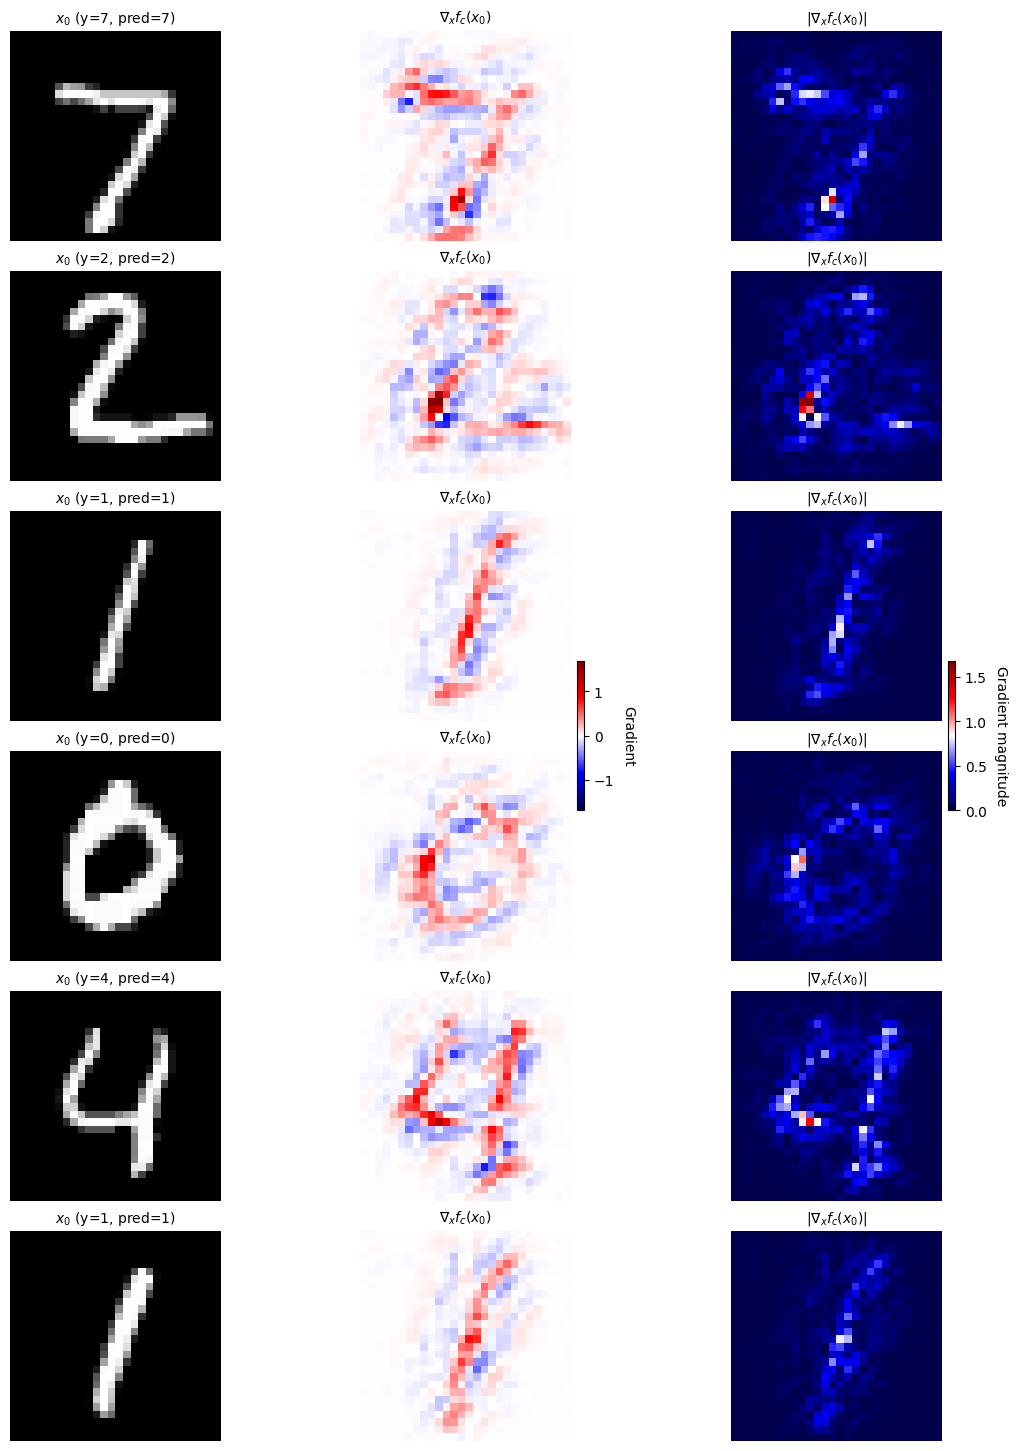

In [6]:
# Raw gradient + magnitude visualization with colorbars
#
# Assumes the following are already defined:
#   device, model (loaded + eval), test_ds, good_idxs

import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Choose examples
# -----------------------

# Number of examples to display
N = 6

# Fixed indices for reproducibility
idxs = good_idxs[:N]

# -----------------------
# Precompute signed gradients to fix color scales
# -----------------------

signed_grads = []

for idx in idxs:
    # Load one test example
    x0, _ = test_ds[int(idx)]

    # Create a leaf tensor so gradients are tracked w.r.t. the input
    x = x0.unsqueeze(0).to(device).detach().clone()

    # Enable gradient computation for the input
    x.requires_grad_(True)

    # Forward pass through the network
    logits = model(x)

    # Choose scalar output: predicted-class logit
    c = int(logits.argmax(dim=1).item())

    # Scalar value whose gradient we compute
    s = logits[0, c]

    # Clear any stale gradients on model parameters
    model.zero_grad(set_to_none=True)

    # Clear any stale gradients on the input
    if x.grad is not None:
        x.grad.zero_()

    # Backpropagate scalar to compute ∂s/∂x
    s.backward()

    # Extract gradient for the single MNIST channel
    g = x.grad.detach().cpu().numpy()[0, 0]

    # Store signed gradient
    signed_grads.append(g)

# Stack signed gradients across examples
signed_grads = np.stack(signed_grads)

# Compute magnitudes once (derived from signed gradients)
mag_grads = np.abs(signed_grads)

# Symmetric limits for signed gradients
vmax_signed = float(np.max(np.abs(signed_grads)))
vmin_signed = -vmax_signed

# Upper bound for gradient magnitude
vmax_mag = float(np.max(mag_grads))

# -----------------------
# Figure
# -----------------------

fig, axes = plt.subplots(
    nrows=N,
    ncols=3,
    figsize=(10.5, 2.4 * N),
    constrained_layout=True
)

# -----------------------
# Plot rows
# -----------------------

for row, idx in enumerate(idxs):
    # Reload the same test example
    x0, y0 = test_ds[int(idx)]

    # Create a fresh leaf tensor for gradient computation
    x = x0.unsqueeze(0).to(device).detach().clone()

    # Enable gradients w.r.t. the input
    x.requires_grad_(True)

    # Forward pass
    logits = model(x)

    # Select predicted-class logit
    c = int(logits.argmax(dim=1).item())

    # Scalar output to differentiate
    s = logits[0, c]

    # Clear old gradients on model
    model.zero_grad(set_to_none=True)

    # Clear old gradients on input
    if x.grad is not None:
        x.grad.zero_()

    # Compute gradient of scalar output w.r.t. input
    s.backward()

    # Extract signed gradient
    grad = x.grad.detach().cpu().numpy()[0, 0]

    # Compute gradient magnitude
    grad_mag = np.abs(grad)

    # Convert grayscale image to RGB for display
    img = x0.numpy()[0]
    img_rgb = np.stack([img, img, img], axis=-1)

    axes[row, 0].imshow(img_rgb)
    axes[row, 0].set_title(f"$x_0$ (y={int(y0)}, pred={c})", fontsize=10)
    axes[row, 0].axis("off")

    im_signed = axes[row, 1].imshow(
        grad,
        cmap="seismic",
        vmin=vmin_signed,
        vmax=vmax_signed
    )
    axes[row, 1].set_title(r"$\nabla_x f_c(x_0)$", fontsize=10)
    axes[row, 1].axis("off")

    im_mag = axes[row, 2].imshow(
        grad_mag,
        cmap="seismic",
        vmin=0.0,
        vmax=vmax_mag
    )
    axes[row, 2].set_title(r"$|\nabla_x f_c(x_0)|$", fontsize=10)
    axes[row, 2].axis("off")

# -----------------------
# Colorbars
# -----------------------

cbar_signed = fig.colorbar(
    im_signed,
    ax=axes[:, 1],
    fraction=0.025,
    pad=0.02
)
cbar_signed.set_label("Gradient", rotation=270, labelpad=15)

cbar_mag = fig.colorbar(
    im_mag,
    ax=axes[:, 2],
    fraction=0.025,
    pad=0.02
)
cbar_mag.set_label("Gradient magnitude", rotation=270, labelpad=15)


## Experiment: Training a Small CNN on CIFAR-10

MNIST is simple: grayscale, centered objects, and low resolution. This makes it a good sandbox for defining and computing input gradients, but it also hides a major issue: *in many image models, raw gradients are visually noisy and unstable*, especially when the input space is higher-dimensional and the task is harder.

CIFAR-10 forces us to confront two practical issues immediately:

1. The input is RGB, so the gradient is a vector field across channels.

2. Training uses normalization and augmentation, so we must be explicit about the representation we differentiate in and how we visualize it.


In [9]:
# train_cifar10_cnn.py
# Minimal CIFAR-10 CNN (PyTorch). Trains, evaluates, and saves weights + a few example indices.
# Designed to be "small but decent" (typically ~75–82% test acc in ~20 epochs on a GPU).

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# -----------------------
# Repro + device
# -----------------------

# Fix random seeds for reproducibility
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

# Prefer CUDA, then Apple MPS, then CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

# -----------------------
# Data
# -----------------------

# CIFAR-10 stored outside the repo; notebook is in a folder, so go up twice
DATA_DIR = "../../datasets/cifar10"

# Mini-batch size
BATCH_SIZE = 128

# CIFAR-10 channel stats (common)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Training transforms include augmentation
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Test transforms are deterministic
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Load CIFAR-10 splits
train_ds = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# -----------------------
# Model
# -----------------------

class SmallCIFAR10CNN(nn.Module):
    """
    f: R^{3x32x32} -> R^{10} logits
    A small VGG-ish stack with BatchNorm + Dropout.
    """
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # 32x32
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

model = SmallCIFAR10CNN().to(device)
print(model)


Device: cuda


/home/rwhite/.local/share/mamba/envs/xai-s26/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


SmallCIFAR10CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, paddi

In [10]:
# -----------------------
# Train setup
# -----------------------

EPOCHS = 20
LR = 1e-3
WD = 5e-4

# AdamW helps a bit for this style of CNN
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

# Cross entropy on logits and integer labels
criterion = nn.CrossEntropyLoss()

# Simple schedule: drop LR late in training
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12, 17], gamma=0.2)

@torch.no_grad()
def evaluate():
    # Switch to eval mode
    model.eval()

    total = 0
    correct = 0
    loss_sum = 0.0

    for x, y in test_loader:
        # Move batch to device
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        logits = model(x)

        # Loss for this batch
        loss = criterion(logits, y)

        # Accumulate weighted loss
        loss_sum += float(loss) * x.size(0)

        # Predicted class
        pred = logits.argmax(dim=1)

        # Count correct predictions
        correct += int((pred == y).sum())
        total += x.size(0)

    return loss_sum / total, correct / total

# -----------------------
# Training loop
# -----------------------

for epoch in range(1, EPOCHS + 1):
    # Switch to train mode
    model.train()

    running_loss_sum = 0.0
    running_steps = 0

    for step, (x, y) in enumerate(train_loader, start=1):
        # Move batch to device
        x = x.to(device)
        y = y.to(device)

        # Clear gradients
        optimizer.zero_grad(set_to_none=True)

        # Forward
        logits = model(x)

        # Loss
        loss = criterion(logits, y)

        # Backward
        loss.backward()

        # Update params
        optimizer.step()

        # Track loss for printing
        running_loss_sum += float(loss)
        running_steps += 1

        if step % 200 == 0:
            avg = running_loss_sum / running_steps
            print(f"Epoch {epoch} Step {step}/{len(train_loader)}  loss={avg:.4f}")
            running_loss_sum = 0.0
            running_steps = 0

    # Step the LR scheduler once per epoch
    scheduler.step()

    # Evaluate
    test_loss, test_acc = evaluate()
    lr_now = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch} DONE  lr={lr_now:.2e}  test_loss={test_loss:.4f}  test_acc={test_acc:.4f}")

# -----------------------
# Save weights + fixed test indices
# -----------------------

# Output folder for this experiment
OUTDIR = "runs_cifar10"
os.makedirs(OUTDIR, exist_ok=True)

# Save model weights
WEIGHTS_PATH = f"{OUTDIR}/cifar10_cnn.pt"
torch.save(model.state_dict(), WEIGHTS_PATH)
print("Saved:", WEIGHTS_PATH)

# Save correctly-classified test indices for reproducible viz
model.eval()
good_idxs = []

with torch.no_grad():
    for idx in range(len(test_ds)):
        # Pull one test example (already normalized)
        x, y = test_ds[idx]

        # Add batch dimension and move to device
        x1 = x.unsqueeze(0).to(device)

        # Forward
        logits = model(x1)
        pred = int(logits.argmax(dim=1).item())

        # Keep only correct examples
        if pred == int(y):
            good_idxs.append(idx)

        if len(good_idxs) >= 25:
            break

good_idxs_path = f"{OUTDIR}/good_test_indices.npy"
np.save(good_idxs_path, np.array(good_idxs, dtype=np.int64))
print("Saved:", good_idxs_path, "count:", len(good_idxs))

Epoch 1 Step 200/391  loss=1.8173
Epoch 1 DONE  lr=1.00e-03  test_loss=1.3207  test_acc=0.5254
Epoch 2 Step 200/391  loss=1.1671
Epoch 2 DONE  lr=1.00e-03  test_loss=1.0510  test_acc=0.6348
Epoch 3 Step 200/391  loss=0.9331
Epoch 3 DONE  lr=1.00e-03  test_loss=0.8631  test_acc=0.6870
Epoch 4 Step 200/391  loss=0.8104
Epoch 4 DONE  lr=1.00e-03  test_loss=0.8642  test_acc=0.7093
Epoch 5 Step 200/391  loss=0.7081
Epoch 5 DONE  lr=1.00e-03  test_loss=0.7393  test_acc=0.7496
Epoch 6 Step 200/391  loss=0.6488
Epoch 6 DONE  lr=1.00e-03  test_loss=0.6416  test_acc=0.7790
Epoch 7 Step 200/391  loss=0.5843
Epoch 7 DONE  lr=1.00e-03  test_loss=0.7708  test_acc=0.7570
Epoch 8 Step 200/391  loss=0.5377
Epoch 8 DONE  lr=1.00e-03  test_loss=0.5109  test_acc=0.8267
Epoch 9 Step 200/391  loss=0.4905
Epoch 9 DONE  lr=1.00e-03  test_loss=0.5065  test_acc=0.8335
Epoch 10 Step 200/391  loss=0.4514
Epoch 10 DONE  lr=1.00e-03  test_loss=0.4409  test_acc=0.8527
Epoch 11 Step 200/391  loss=0.4317
Epoch 11 DONE

Device: cuda
Saved: figs_cifar10/cifar10_rgb_channel_gradients_and_l2norm_rows.png


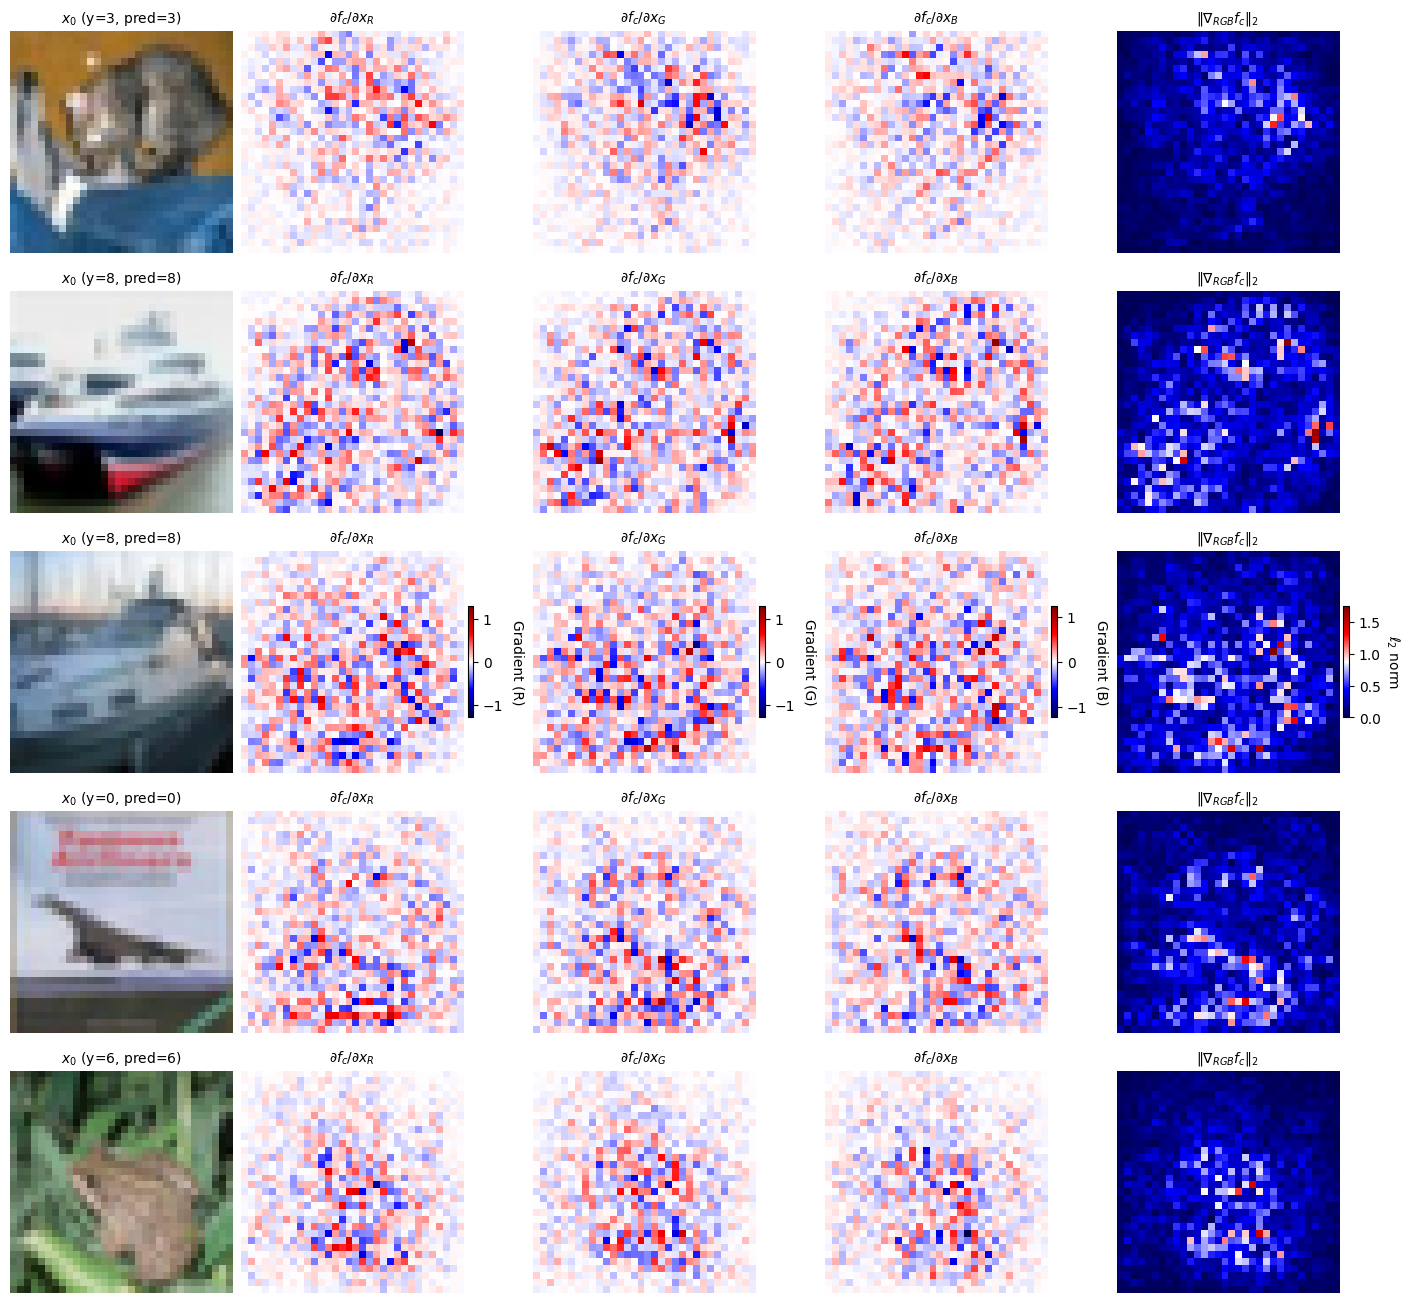

In [13]:
# CIFAR-10: per-channel gradient + gradient-norm visualization
# Columns:
#   input | ∂f/∂x_R | ∂f/∂x_G | ∂f/∂x_B | ||∇_{RGB} f||_2

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# -----------------------
# Paths / device
# -----------------------

# Locations saved by the training script
OUTDIR = "runs_cifar10"
WEIGHTS_PATH = f"{OUTDIR}/cifar10_cnn.pt"
GOOD_IDXS_PATH = f"{OUTDIR}/good_test_indices.npy"

# Folder for figures
FIGDIR = "figs_cifar10"
os.makedirs(FIGDIR, exist_ok=True)

# Device selection
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

# -----------------------
# CIFAR-10 normalization (must match training)
# -----------------------

# Channel-wise normalization used during training
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Test-time transform (no augmentation)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Tensors for undoing normalization (display only)
mean = torch.tensor(CIFAR10_MEAN).view(3, 1, 1)
std  = torch.tensor(CIFAR10_STD).view(3, 1, 1)

def unnormalize(x_chw: torch.Tensor) -> torch.Tensor:
    # Map normalized image back to [0,1] for visualization
    y = x_chw * std + mean
    return y.clamp(0.0, 1.0)

# -----------------------
# Load model
# -----------------------

# Reuse model if already defined
try:
    model
except NameError:
    model = SmallCIFAR10CNN().to(device)

# Load saved weights
try:
    state = torch.load(WEIGHTS_PATH, map_location=device, weights_only=True)
except TypeError:
    state = torch.load(WEIGHTS_PATH, map_location=device)

model.load_state_dict(state)

# Disable dropout / batchnorm updates
model.eval()

# -----------------------
# Dataset + indices
# -----------------------

# CIFAR-10 test set (normalized)
test_ds = datasets.CIFAR10(
    root="../../datasets/cifar10",
    train=False,
    download=False,
    transform=test_tf
)

# Preselected correctly-classified examples
good_idxs = np.load(GOOD_IDXS_PATH)

# Number of rows to visualize
N = 5
idxs = good_idxs[:N]

# -----------------------
# Precompute gradients to fix color scales
# -----------------------

# Lists for each gradient component
grads_r = []
grads_g = []
grads_b = []
grads_norm = []

for idx in idxs:
    # Load one normalized test image
    x0, _ = test_ds[int(idx)]

    # Create a leaf tensor for input gradients
    x = x0.unsqueeze(0).to(device).detach().clone()

    # Enable gradient tracking w.r.t. input pixels
    x.requires_grad_(True)

    # Forward pass
    logits = model(x)

    # Select scalar: predicted-class logit
    c = int(logits.argmax(dim=1).item())
    s = logits[0, c]

    # Clear any stale gradients
    model.zero_grad(set_to_none=True)
    if x.grad is not None:
        x.grad.zero_()

    # Backpropagate scalar to input
    s.backward()

    # Extract gradient array with shape (3, 32, 32)
    g = x.grad.detach().cpu().numpy()[0]

    # Split channels
    r = g[0]
    gch = g[1]
    b = g[2]

    # Compute channelwise L2 norm
    nrm = np.sqrt(r*r + gch*gch + b*b)

    # Store for color scaling
    grads_r.append(r)
    grads_g.append(gch)
    grads_b.append(b)
    grads_norm.append(nrm)

# Stack gradients across examples
grads_r = np.stack(grads_r)
grads_g = np.stack(grads_g)
grads_b = np.stack(grads_b)
grads_norm = np.stack(grads_norm)

# Symmetric color limits for signed gradients
vmax_r = float(np.max(np.abs(grads_r))); vmin_r = -vmax_r
vmax_g = float(np.max(np.abs(grads_g))); vmin_g = -vmax_g
vmax_b = float(np.max(np.abs(grads_b))); vmin_b = -vmax_b

# Nonnegative limit for gradient norm
vmax_norm = float(np.max(grads_norm))

# -----------------------
# Figure
# -----------------------

fig, axes = plt.subplots(
    nrows=N,
    ncols=5,
    figsize=(14.0, 2.6 * N),
    constrained_layout=True
)

# -----------------------
# Plot rows
# -----------------------

for row, idx in enumerate(idxs):
    # Reload the same test example
    x0, y0 = test_ds[int(idx)]

    # Fresh leaf tensor for gradients
    x = x0.unsqueeze(0).to(device).detach().clone()
    x.requires_grad_(True)

    # Forward pass
    logits = model(x)

    # Predicted-class scalar
    c = int(logits.argmax(dim=1).item())
    s = logits[0, c]

    # Clear gradients
    model.zero_grad(set_to_none=True)
    if x.grad is not None:
        x.grad.zero_()

    # Compute ∂f_c / ∂x
    s.backward()

    # Extract per-channel gradients
    grad = x.grad.detach().cpu().numpy()[0]
    grad_r = grad[0]
    grad_g = grad[1]
    grad_b = grad[2]

    # Compute gradient norm
    grad_n = np.sqrt(grad_r*grad_r + grad_g*grad_g + grad_b*grad_b)

    # Unnormalize image for display
    x_disp = unnormalize(x0.cpu()).permute(1, 2, 0).numpy()

    # Input image
    axes[row, 0].imshow(x_disp)
    axes[row, 0].set_title(f"$x_0$ (y={int(y0)}, pred={c})", fontsize=10)
    axes[row, 0].axis("off")

    # Red-channel sensitivity
    im_r = axes[row, 1].imshow(grad_r, cmap="seismic", vmin=vmin_r, vmax=vmax_r)
    axes[row, 1].set_title(r"$\partial f_c/\partial x_R$", fontsize=10)
    axes[row, 1].axis("off")

    # Green-channel sensitivity
    im_g = axes[row, 2].imshow(grad_g, cmap="seismic", vmin=vmin_g, vmax=vmax_g)
    axes[row, 2].set_title(r"$\partial f_c/\partial x_G$", fontsize=10)
    axes[row, 2].axis("off")

    # Blue-channel sensitivity
    im_b = axes[row, 3].imshow(grad_b, cmap="seismic", vmin=vmin_b, vmax=vmax_b)
    axes[row, 3].set_title(r"$\partial f_c/\partial x_B$", fontsize=10)
    axes[row, 3].axis("off")

    # Gradient magnitude
    im_n = axes[row, 4].imshow(grad_n, cmap="seismic", vmin=0.0, vmax=vmax_norm)
    axes[row, 4].set_title(r"$\|\nabla_{RGB} f_c\|_2$", fontsize=10)
    axes[row, 4].axis("off")

# -----------------------
# Colorbars
# -----------------------

cbar_r = fig.colorbar(im_r, ax=axes[:, 1], fraction=0.025, pad=0.02)
cbar_r.set_label("Gradient (R)", rotation=270, labelpad=15)

cbar_g = fig.colorbar(im_g, ax=axes[:, 2], fraction=0.025, pad=0.02)
cbar_g.set_label("Gradient (G)", rotation=270, labelpad=15)

cbar_b = fig.colorbar(im_b, ax=axes[:, 3], fraction=0.025, pad=0.02)
cbar_b.set_label("Gradient (B)", rotation=270, labelpad=15)

cbar_n = fig.colorbar(im_n, ax=axes[:, 4], fraction=0.025, pad=0.02)
cbar_n.set_label(r"$\ell_2$ norm", rotation=270, labelpad=15)

# -----------------------
# Save
# -----------------------

out_png = f"{FIGDIR}/cifar10_rgb_channel_gradients_and_l2norm_rows.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")

print("Saved:", out_png)
